In this model, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be done with words or other higher order constructs) is often referred to as a “language model”.

In [185]:
from io import open
import glob
import os

import unicodedata
import string

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [186]:
print(glob.glob('./data/names/*.txt'))

['./data/names/Arabic.txt', './data/names/Chinese.txt', './data/names/Czech.txt', './data/names/Dutch.txt', './data/names/English.txt', './data/names/French.txt', './data/names/German.txt', './data/names/Greek.txt', './data/names/Irish.txt', './data/names/Italian.txt', './data/names/Japanese.txt', './data/names/Korean.txt', './data/names/Polish.txt', './data/names/Portuguese.txt', './data/names/Russian.txt', './data/names/Scottish.txt', './data/names/Spanish.txt', './data/names/Vietnamese.txt']


In [187]:
all_letters = string.ascii_letters + ",.;-'"
n_letters = len(all_letters) + 1 # Plus EOS marker i.e. index of EOS

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if c in all_letters and unicodedata.category(c) != 'Mn'
    )

print(unicodeToAscii("O'Néàl"))

O'Neal


In [188]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


### Creating the Network

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer o2o (after combining hidden and output) to give it more muscle to work with. There’s also a dropout layer, which randomly zeros parts of its input with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we’re using it towards the end of the network to purposely add some chaos and increase sampling variety.

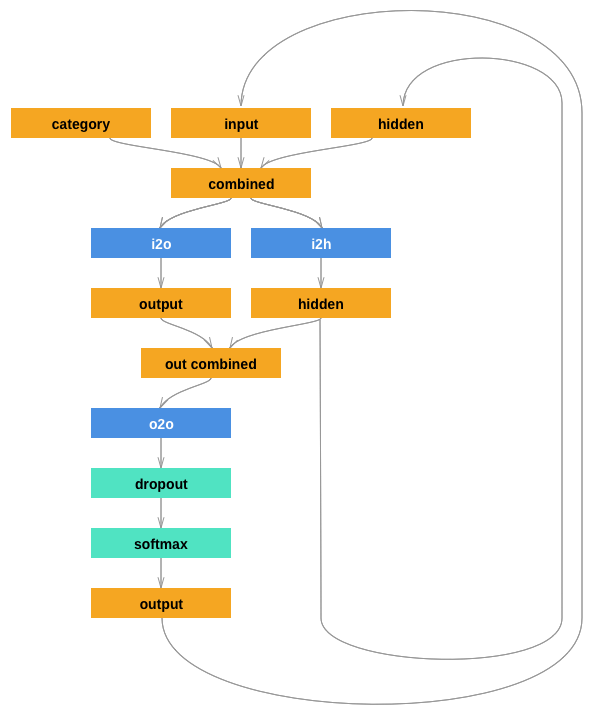

In [189]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size + n_categories, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size + n_categories, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    

### Training

#### Preparing for Training
For each timestep (that is, for each letter in a training word) the inputs of the network will be (category, current letter, hidden state) and the outputs will be (next letter, next hidden state). So for each training set, we’ll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for "ABCD<EOS>" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).

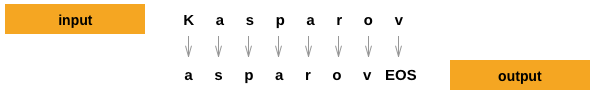

The category tensor is a one-hot tensor of size <1 x n_categories>. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.


In [190]:
# One-hot vector for category
def categoryTensor(category):
    ind = all_categories.index(category) # Get the index of the category
    tensor = torch.zeros(1, n_categories)
    tensor[0][ind] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for ind in range(len(line)):
        letter = line[ind]
        tensor[ind][0][all_letters.index(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = []
    for letter in line[1:]:
        letter_indexes.append(all_letters.index(letter))
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [191]:
def randomTrainingExample():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor
    

#### Training the Network
In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

In [192]:
model = RNN(n_letters, 128, n_letters)
loss_fn = nn.NLLLoss()
lr = 0.0005
optimizer = optim.SGD(model.parameters(), lr=lr)

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()

    model.zero_grad()
    losses = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        l = loss_fn(output, target_line_tensor[i])
        losses += l

    losses.backward()
    optimizer.step()
    return output, losses.item()/input_line_tensor.size(0)

    

In [193]:
n_iters = 250000
print_every = 5000

losses = []
cur_loss = 0

for i in range(1, n_iters+1):
    category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, input_line_tensor, target_line_tensor)
    cur_loss += loss
    if i%print_every == 0:
        losses.append(cur_loss/print_every)
        print(f'Iter {i} loss: {cur_loss / print_every:.4f}')
        cur_loss = 0


Iter 5000 loss: 3.2117
Iter 10000 loss: 2.8588
Iter 15000 loss: 2.7275
Iter 20000 loss: 2.6485
Iter 25000 loss: 2.5899
Iter 30000 loss: 2.5436
Iter 35000 loss: 2.5022
Iter 40000 loss: 2.4807
Iter 45000 loss: 2.4522
Iter 50000 loss: 2.4212
Iter 55000 loss: 2.4210
Iter 60000 loss: 2.3968
Iter 65000 loss: 2.3743
Iter 70000 loss: 2.3611
Iter 75000 loss: 2.3467
Iter 80000 loss: 2.3430
Iter 85000 loss: 2.3412
Iter 90000 loss: 2.3339
Iter 95000 loss: 2.3168
Iter 100000 loss: 2.3072
Iter 105000 loss: 2.3064
Iter 110000 loss: 2.2949
Iter 115000 loss: 2.2731
Iter 120000 loss: 2.2753
Iter 125000 loss: 2.2716
Iter 130000 loss: 2.2684
Iter 135000 loss: 2.2681
Iter 140000 loss: 2.2366
Iter 145000 loss: 2.2587
Iter 150000 loss: 2.2415
Iter 155000 loss: 2.2456
Iter 160000 loss: 2.2303
Iter 165000 loss: 2.2381
Iter 170000 loss: 2.2177
Iter 175000 loss: 2.2180
Iter 180000 loss: 2.2159
Iter 185000 loss: 2.2174
Iter 190000 loss: 2.2017
Iter 195000 loss: 2.2139
Iter 200000 loss: 2.2051
Iter 205000 loss: 2.

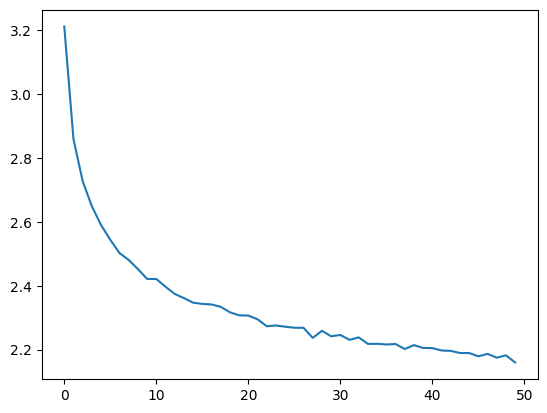

In [194]:
plt.figure()
plt.plot(losses)

### Sampling the Network
To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.

- Create tensors for input category, starting letter, and empty hidden state
- Create a string output_name with the starting letter
- Up to a maximum output length,
    - Feed the current letter to the network
    - Get the next letter from highest output, and next hidden state
    - If the letter is EOS, stop here
    - If a regular letter, add to output_name and continue
- Return the final name

In [195]:
max_length = 20
def sample(category, start_letter='N'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = model.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = model(category_tensor, input[0], hidden)
            topi = output.argmax()
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
        
        return output_name
    
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))


In [196]:
samples('Polish', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')


Alddd
Baaaaeeazkzczzzzaaziz
Coaellkkkk
Doaooaaiiiiccaoiiiiii
Essssk
Foerrerrrrrrrereeeeee
Goaeeeaaiiiaiaaaaiiii
Haaaaaaaiiaiaaaaaiiii
Irsl
Jaaooea
Koooeee
Liaeee
Moacoaaaiicccccczazaz
Naaaaeikk
Olkkkkkkkk
Paaeeeaeeekzeaeaaaaii
Qiuaaaaaiiiiiaaaaaiii
Rooiiiiiiiiiiiii
Siakkakkkkkiiioiii
Toaaeeskkk
Uosee
Viaeaiiiiiiiiiiiiiici
Waaieei
Xiaeeei
Yoaaaaa
Zoaeeaek


In [197]:
samples('Chinese', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')


Ann
Baaa
Cha
Duaa
Enn
Fiaee
Guao
Haaa
Iua
Jaae
Kaoooo
Lia
Maa
Niao
Ohg
Paaa
Quaou
Rioi
Sha
Thao
Uia
Via
Waa
Xia
Yaoo
Zha


In [198]:
samples('Arabic', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ')

Asbdd
Baaaaaaa
Chhauuu
Doaaaaai
Esss
Faarrrrrrrrrrrrrrrrrr
Gaaaaaa
Haaaaaaa
Isss
Jaaaao
Kaaauu
Laoao
Maaaaaeaai
Naaaaai
Ohbdhh


Paaaaae
Quaauuuu
Raaaaii
Saaaahh
Taaaao
Uoar
Vaaaai
Woaaii
Xaaaa
Yaaaau
Zhhaau
